## Evaluating regression techniques for speaker characterization - Part II
### Laura Fernández Gallardo

In this notebook, I will evaluate the performance of different classification techniques for characterizing users. The aggregated subjective ratings (approximately normally-distributed) will be thresholded based on percentiles to define 3 classes ("high", "mid", and "low") with approximately the same number of samples.

As evaluation metrics, I will consider the per-class accuracy. Less confusions between the "high" and the "low" class are desired, while low accuracy recognizing the "middle class" would be less critical.

Let us start by looking at the traits for which listeners had slightly higher agreement: 

* _intelligent_
* _ugly_
* _old_
* _modest_
* _incompetent_

The files "SC_ratings_medians.csv" and "SC_ratings_medians.csv" have been generated in this folder.

In [52]:
import io
import requests

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

In [3]:
# load ratings (averaged across listeners)
ratings_means = pd.read_csv("SC_ratings_means.csv")

ratings_class = pd.DataFrame(index = ratings_means.index, columns=ratings_means.columns)

# for each trait, assign instances into 3 classes
for i in ratings_means.columns[2:]:
    # percentiles to threshold
    th = np.percentile(ratings_means[i],[33,66])
    ratings_class.loc[ratings_means[i]<th[0],i] = "low" 
    ratings_class.loc[ratings_means[i]>=th[0],i] = "mid" 
    ratings_class.loc[ratings_means[i]>th[1],i] = "high"
    
ratings_class.iloc[:,0:2] = ratings_means.iloc[:,0:2]     

In [4]:
# load speech features from male and from female speakers

path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/"

# load subjective questionnaire items and their translations
url = path + "eGeMAPSv01a_88_malespk.csv"
s = requests.get(url).content
feats_m =pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "eGeMAPSv01a_88_femalespk.csv"
s = requests.get(url).content
feats_f =pd.read_csv(io.StringIO(s.decode('utf-8')))


Pre-processing features:

* join males and females and add 1-hot encoded gender feature
* center and scale speech features of all data
* apply PCA to reduce the number of predictors

In [5]:
# all features: males and females
feats_m['is_male']=1
feats_f['is_male']=0
feats = pd.concat([feats_m,feats_f], axis = 0)

feats.describe()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0.2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV500.1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,is_male
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,32.178699,0.191036,29.195479,32.497615,35.487213,6.291734,305.132620,465.219884,186.614169,331.245254,...,0.007315,0.101039,2.920460,2.119959,0.209901,0.177489,0.262302,0.409198,-27.948955,0.420000
std,5.302460,0.045772,5.689682,5.648273,5.581904,1.852412,136.022019,260.737297,105.738406,260.995846,...,0.002382,0.029991,0.396761,0.273479,0.036660,0.038392,0.045896,0.058930,0.590704,0.494383
min,20.369190,0.090754,15.787630,19.008480,22.374690,2.906771,31.926970,22.507920,39.196000,19.330250,...,0.000072,0.044194,1.942446,1.301048,0.125636,0.095757,0.167581,0.273608,-29.890070,0.000000
25%,26.869380,0.159612,23.741067,26.610455,30.055792,5.058409,204.830225,263.486675,110.990600,135.118500,...,0.005866,0.080424,2.668827,1.936643,0.186137,0.151392,0.229653,0.367679,-28.263147,0.000000
50%,34.349755,0.185110,31.813500,35.243705,38.093775,6.047605,283.111100,418.261650,161.347300,246.758450,...,0.007465,0.095850,2.862824,2.109847,0.205227,0.174578,0.257518,0.405958,-27.940620,0.000000
75%,36.723568,0.215099,34.248635,37.201692,40.152758,7.295743,391.356575,648.698625,237.425725,467.891975,...,0.008959,0.117125,3.187676,2.281939,0.229600,0.198940,0.293525,0.447432,-27.558625,1.000000
max,40.628860,0.331020,38.364490,41.564300,44.217760,18.519420,693.417700,1316.347000,790.193800,1379.039000,...,0.015888,0.223397,4.529817,3.162737,0.397500,0.346722,0.436176,0.604454,-26.284370,1.000000


In [6]:
# extract speaker ID from sample_heard

feats['speaker_ID'] = feats['sample_heard'].str.slice(1, 4)
feats.head()

,sample_heard,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0.2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,...,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,is_male,speaker_ID
0,m004_linden_stimulus.wav,29.21275,0.228334,24.89525,28.53454,32.79715,7.901901,693.4177,1157.7970,131.25300,...,0.094820,2.751376,1.905717,0.203684,0.205560,0.343333,0.480471,-27.55720,1,004
1,m005_nicosia_stimulus.wav,27.97981,0.162944,24.77392,28.57069,31.23656,6.462639,157.3337,220.8215,75.38364,...,0.060881,2.606429,1.741402,0.277000,0.215467,0.284103,0.532872,-28.37694,1,005
2,m006_rabat_stimulus.wav,31.96671,0.225099,26.73639,31.80232,36.81213,10.075740,311.8069,588.8658,118.47730,...,0.064211,2.687209,1.687007,0.274043,0.259022,0.318409,0.461509,-27.53427,1,006
3,m007_klaksvik_stimulus.wav,24.47457,0.188403,22.10289,24.46268,27.27474,5.171844,211.0591,318.7577,393.00220,...,0.088696,3.559871,1.753247,0.252222,0.211841,0.276896,0.399276,-28.62894,1,007
4,m016_beirut_stimulus.wav,30.19319,0.243157,26.37834,29.65022,33.01906,6.640724,271.1996,315.2922,172.59070,...,0.085694,3.439804,1.822660,0.247027,0.301186,0.323437,0.506289,-28.85239,1,016


In [7]:
# Standardize speech features  

scaler = StandardScaler()
scaler.fit(feats.drop(['sample_heard','is_male','speaker_ID'],axis=1))
feats_s = scaler.transform(feats.drop(['sample_heard','is_male','speaker_ID'],axis=1)) # numpy 300x88

In [8]:
# Apply PCA and examine how many components to retain

pca = PCA()
pca.fit(feats_s)
feats_pca = pca.transform(feats_s) # np array 300 x n_pca-components
np.round(pca.explained_variance_ratio_,2)

array([ 0.21,  0.13,  0.11,  0.06,  0.05,  0.03,  0.03,  0.03,  0.03,
        0.02,  0.02,  0.02,  0.02,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

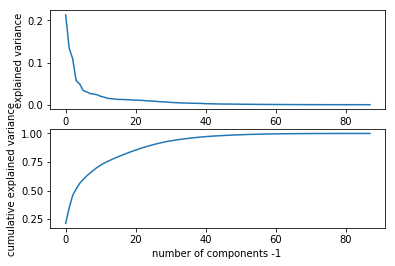

In [9]:
# Explained variance

plt.subplot(2, 1, 1)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components -1 ')
plt.ylabel('explained variance')

plt.subplot(2, 1, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components -1 ')
plt.ylabel('cumulative explained variance')

plt.show()

We will retain the first 5 principal components, which account for 51% of the explained variance.

In [10]:
# selected pca components as pandas data frame
feats_pca_pd = pd.DataFrame(feats_pca[:,0:5], columns = np.char.mod('PC_%d', np.arange(5)))

# adding speaker one-hot encoded gender 
feats_pca_pd.loc[:,'is_male']=feats['is_male'].values

Text(0,0.5,'PC_1')

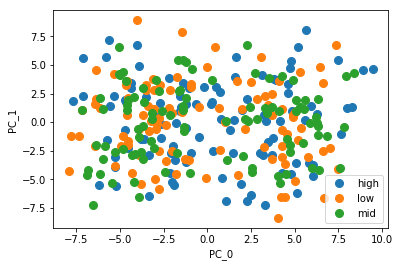

In [46]:
# plot first pca components for one trait

feats_grouped = feats_pca_pd.groupby(ratings_class['intelligent'].astype("category"))

fig, ax = plt.subplots()
for name, group in aa:
    ax.plot(group.PC_0, group.PC_1, marker='o', linestyle='', ms=8, label=name)
ax.legend()
ax.set_xlabel('PC_0')
ax.set_ylabel('PC_1')

It looks like the class separation is going to be challenging!

### Model tuning

Let us go on with:

Database partitions: consider train/dev partitions and cross-validation.
Test data will be utterances from other dialogues, given the (somewhat strong) assumption that traits stay constant over time.

* Split the available data to find the model and its hyperparameters leading to the best performance 
* Stratified cross-validation for hyperparameter tuning
* Check performance in test

(Nested hyperparameter tuning inspired by [A. Zheng](http://www.oreilly.com/data/free/evaluating-machine-learning-models.csp))

In [49]:
X = feats_pca_pd.values
y = ratings_class['intelligent']

# for mf in model_family_list:
    
# split data into 80% and 20% subsets
# give subset A to the inner hyperparameter tuner,
# save subset B for meta-evaluation
AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, random_state=2302)


In [72]:
## (quick working example knn)

from sklearn.neighbors import KNeighborsClassifier
knn2 = KNeighborsClassifier(n_neighbors=1)
knn2.fit(AX, Ay)
print("mean accuracy =",knn2.score(BX,By)) # this is the same as average recall of classif report
pred = knn2.predict(BX)
print(classification_report(By,pred))
print(confusion_matrix(By, pred)) # i = true / j = predicted
#sns.heatmap(cm)

mean accuracy = 0.466666666667
             precision    recall  f1-score   support

       high       0.42      0.50      0.46        16
        low       0.61      0.44      0.51        25
        mid       0.39      0.47      0.43        19

avg / total       0.49      0.47      0.47        60

[[ 8  3  5]
 [ 5 11  9]
 [ 6  4  9]]


Hyperparam tuning using only subset A (AX, Ay) <- GridSearchCV

In [ ]:
# all imports (classifiers)

from sklearn.neighbors import KNeighborsClassifier

In [119]:
# init lists

classifiers_names = []
classifiers = []
hparam_grids = []
grid_results = []
best_accs = [] # on the B set
best_hps = [] 

K Nearest Neighbors

In [120]:
knn = KNeighborsClassifier()

n_neighbors = list(range(1,50))
hp = dict(n_neighbors = n_neighbors)

# append classifier and parameters to our lists
classifiers_names.append("K Nearest Neighbors")
classifiers.append(knn)
hparam_grids.append(hp)

#### Hyperparameter tuning for each classifier

Helper functions

In [125]:
# summarize results given 
# - classifier name
# - gridsearch results for a classifier 
# - and name of file to write the summary to

def summary_tuning(cname, grid_result, file):
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    # print best result and append to our lists
    print("%r -> Best: %f using %s\n" % (cname, grid_result.best_score_, grid_result.best_params_))

    # write means, stds, params to file
    file.write("\n")
    for mean, stdev, param in zip(means, stds, params):
        file.write("%r, %f (%f) with: %r\n" % (cname, mean, stdev, param))

In [126]:
# main loop to tune hyperparameters for each classifier

for i in np.arange(len(classifiers)):
    
    # perform grid search
    grid = GridSearchCV(estimator=classifiers[i], 
                        param_grid=hparam_grids[i], 
                        n_jobs=1, 
                        cv=10)
    grid_result = grid.fit(AX, Ay) # This takes a while
    
    # append grid search results to our lists
    grid_results.append(grid_result)
    
    # summary of hp tuning
    summary_tuning(classifiers_names[i], 
                   grid_result, 
                   open("summary.txt","a"))
    
    # evaluate classifier on set B
    test_score = grid_result.best_estimator_.score(BX, By)
    best_accs.append(test_score)
    best_hps.append(grid_result.best_params_)
    
    

'K Nearest Neighbors' -> Best: 0.379167 using {'n_neighbors': 3}



Cross-validation for partitions A-B: 
- make an average of best_accs after testing for each classifier


Now, select the classifier that gave the maximum acc on B.

In [160]:
# select classifier based on max acc on B set
index = best_accs.index(max(best_accs))
cls = classifiers[index]
cls.set_params(**best_hps[index])

# train using all data with this classifier
cls.fit(X,y)

# X,y would be from my train data. 
# Then, I have test data from other dialogs - let us see the performance

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
# Now, do all this stuff in CV (in each fold, use different A, B data)

# I think this would be the way to go:
k_fold = StratifiedKFold(n_splits=3)
[my_function() for train, test in k_fold.split(X_digits)]


In [ ]:
## (pseudocode from Zheng)

model_model_family_list=[]
perf_list = []
hp_list = []

X = feats_pca_pd
y = ratings_class['intelligent']

for mf in model_family_list:
    
    # split data into 80% and 20% subsets
    # give subset A to the inner hyperparameter tuner,
    # save subset B for meta-evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.33, 
                                                        random_state=2302)

    # further split A into training and validation sets
    C, D = train_test_split(A, 0.8)

    # generate_hp_candidates should be a function that knows
    # how to generate candidate hyperparameter settings
    # for any given model family
    hp_settings_list = generate_hp_candidates(mf)

    # run hyperparameter tuner to find best hyperparameters
    best_hp, best_m = hyperparameter_tuner(C, D,
    hp_settings_list)
    result = evaluate(best_m, B)
    perf_list.append(result)
    hp_list.append(best_hp)

    # end of inner hyperparameter tuning loop for a single
    # model family
    
# find best model family (max_index is a helper function
# that finds the index of the maximum element in a list)
best_mf = model_family_list[max_index(perf_list)]
best_hp = hp_list[max_index(perf_list)]

# train a model from the best model family using all of
# the data
model = train_mf_model(best_mf, best_hp, data)